In [113]:
from dask.distributed import Client, progress
import dask
import pandas as pd
import fsspec 
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import scipy.stats as stats


In [ ]:
# Setting up clients for DASK and Amazon webservices

try:
    from dask.distributed import get_client
    get_client().close()
except Exception:
    pass

client = Client()  # set up local cluster on your laptop
client

fs = fsspec.filesystem('s3', anon=True)

In [ ]:
# Setting up the base url to retrieve precipitation files. There are two values of precipitation
# in this dataset, large-scale precipitation (lsp) and convective precipitation (cp). To find total precipitation
# you must combine the two. There are also multiple files per month, so I set up the framework for each type
# of precip per month, and then use fs.glob to find all the relevant files.

base_url = 's3://nsf-ncar-era5/e5.oper.fc.sfc.accumu/'
base_url2 = '/e5.oper.fc.sfc.accumu.128_'
base_url3 = '_*.nc'

lsp_tag = '142'
cp_tag = '143'

center_coords = [47.5, -122.3] # latitude/longitude for Seattle, Wa

lat_bounds = [center_coords[0] + 5, center_coords[0] - 5]
lon_bounds = [center_coords[1]- 5 + 360, center_coords[1] + 5 + 360]

# period of interest
pr = pd.date_range(start='1990-01',end='2020-12', freq='MS')

lsp_file_list=[]
cp_file_list=[]
for dt in pr:
    
    year_month = dt.strftime('%Y%m')

    # build glob file names for cp and lsp
    
    # lsp
    single_file=(base_url+year_month+base_url2+lsp_tag+base_url3)
    lsp_file_list.append(single_file)

    # cp
    single_file=(base_url+year_month+base_url2+cp_tag+base_url3)
    cp_file_list.append(single_file)

In [ ]:
# using fs.glob to construct the complete file list.
lsp_final_list = []
cp_final_list = []

for file in lsp_file_list:
    lsp_final_list = lsp_final_list + fs.glob(file)

for file in cp_file_list:
    cp_final_list = cp_final_list + fs.glob(file)

lsp_final_list = ['s3://' + item for item in lsp_final_list]
cp_final_list = ['s3://' + item for item in cp_final_list]

In [ ]:
lsp_ds = xr.open_mfdataset(
    #    cached,
        lsp_final_list,
        combine="by_coords",
        engine="h5netcdf",         # or "h5netcdf"
        chunks={"time": 12},      # modest time chunks
        parallel=False, 
        backend_kwargs={"storage_options": {"anon": True }},
        
)

cp_ds = xr.open_mfdataset(
    #    cached,
        cp_final_list,
        combine="by_coords",
        engine="h5netcdf",         # or "h5netcdf"
        chunks={"time": 12},      # modest time chunks
        parallel=False, 
        backend_kwargs={"storage_options": {"anon": True }},
)

cp_ds = cp_ds.sel(latitude = slice(lat_bounds[0], lat_bounds[1]), longitude = slice(lon_bounds[0], lon_bounds[1]))
lsp_ds = lsp_ds.sel(latitude = slice(lat_bounds[0], lat_bounds[1]), longitude = slice(lon_bounds[0], lon_bounds[1]))
cp_ds.to_netcdf('Data/cp_seattle_1990-2000.nc')
lsp_ds.to_netcdf('Data/lsp_seattle_1990-2000.nc')

Start Here if you've already made datasets

In [ ]:
# Loading convective precip and large scale precip for Seattle
lsp_ds = xr.open_dataset(
                        'Data/cp_seattle_1990-2020.nc',
                         )
cp_ds = xr.open_dataset(
                        'Data/lsp_seattle_1990-2020.nc',
                        )

# Loading US total precip

US_precip = xr.open_dataset('Data/ERA-5_total_precipitation_monthly-1981-2020.nc')

Question 1

In [95]:
lsp_ds = lsp_ds.stack(time = ('forecast_initial_time', 'forecast_hour'))

datetime = []

for i, _ in enumerate(lsp_ds['time']):
   
   datetime.append(lsp_ds['time'].values[i][0] + pd.to_timedelta(lsp_ds['time'].values[i][1], unit = 'h'))



lsp_ds = lsp_ds.assign_coords(datetime = ('time', datetime))
lsp_ds.swap_dims({'time': 'datetime'})

lsp_mean = lsp_ds['LSP'].mean(('latitude', 'longitude'))

lsp_daily_mean = lsp_mean.resample(datetime = 'D').sum()

In [96]:
cp_ds = cp_ds.stack(time = ('forecast_initial_time', 'forecast_hour'))

datetime = []

for i, _ in enumerate(cp_ds['time']):
   
   datetime.append(cp_ds['time'].values[i][0] + pd.to_timedelta(cp_ds['time'].values[i][1], unit = 'h'))



cp_ds = cp_ds.assign_coords(datetime = ('time', datetime))
cp_ds.swap_dims({'time': 'datetime'})

cp_mean = cp_ds['CP'].mean(('latitude', 'longitude'))

cp_daily_mean = cp_mean.resample(datetime = 'D').sum()

In [97]:
# adding large scale and convective precip together and converting to milimeters
total_precip_daily_mean = (cp_daily_mean + lsp_daily_mean) * 1000

Text(0, 0.5, 'mm/day')

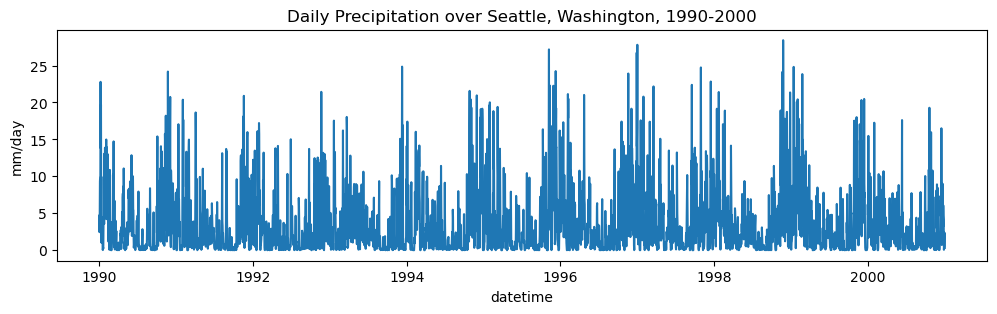

In [ ]:
# Plotting total precipitation
total_precip_daily_mean.plot(
    aspect = 4,
    size = 3,
)

plt.title('Daily Precipitation over Seattle, Washington, 1990-2000')
plt.ylabel('mm/day')

Question 2

In [ ]:
seattle_precip_fit = stats.gamma.fit(total_precip_daily_mean.values)
x = np.linspace(min(total_precip_daily_mean.values),max(total_precip_daily_mean.values),100)
cdf = stats.gamma.cdf(x, *seattle_precip_fit)
precip_95 = stats.gamma.ppf(0.95, *seattle_precip_fit)

Text(0.5, 1.0, 'Cumulative Distribution of Daily Precipitation over Seattle, WA, 1990-2000')

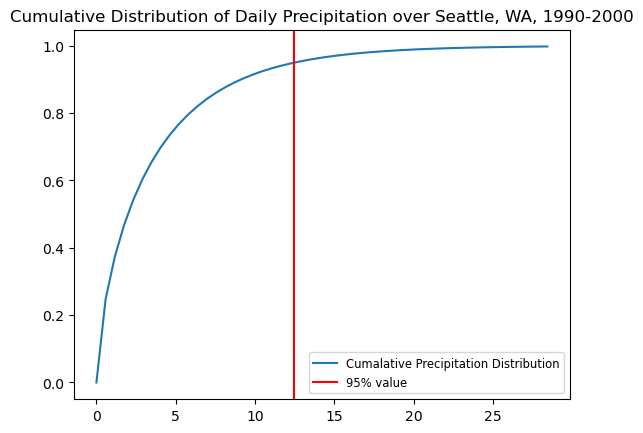

In [179]:
plt.plot(x, cdf, label = 'Cumalative Precipitation Distribution')
plt.axvline(precip_95, c = 'r', label = '95% value')
plt.legend(fontsize = 'small')
plt.title('Cumulative Distribution of Daily Precipitation over Seattle, WA, 1990-2000')